 The following chunk gets input and spits out "cities" variable that is a pandas dataframe of cities inputed that also has "n_people" column

In [1]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
import numpy as np


# Get Input
df = pd.read_csv ('world_cities_modified.csv')
cities = pd.DataFrame(columns = ["index","city","city_ascii","lat","lng","country","iso2","iso3","admin_name","capital","population","id","gmtOffset"])
n_people = []

print("Enter two zeros (0 0) to end")

while True:
    inp = input("Enter the name of the city: ")
    if inp == "0 0":
        break
    rslt_df = df[df["city_ascii"] == inp]
    id = 1
    if rslt_df.shape[0] > 1:
        for index, row in rslt_df.iterrows():
            print(f"{id}: Did you mean {row['city_ascii']}, {row['admin_name']}, {row['country']}")
            id += 1
        id = int(input("Enter the ID associated with the city: "))

    n_people.append(int(input("Enter the number of people from that city: ")))
    cities.loc[len(cities)] = rslt_df.iloc[id-1]

cities["n_people"] = n_people 

# Turku Vilnius Lviv Bucharest Kigali Lusaka Bloemfontein 
# Paris Prague Kyiv Krasnoyarsk Ayan


Enter two zeros (0 0) to end
1: Did you mean Paris, Île-de-France, France
2: Did you mean Paris, Texas, United States
3: Did you mean Paris, Kentucky, United States
4: Did you mean Paris, Tennessee, United States
5: Did you mean Paris, Illinois, United States
6: Did you mean Paris, Maine, United States


In [2]:
for i, row in cities.iterrows():
    print(f"{row['city_ascii']}: {row['n_people']} people")

Paris: 10 people
Prague: 8 people
Kyiv: 4 people
Ufa: 5 people
Omsk: 5 people
Krasnoyarsk: 1 people
Ayan: 10 people


The following  two chunks of code is the algorithm that we are using 
(Needs to change)

In [3]:
#Returns the "height" of the normal function of the given parameters at the point x relative to the mean
def normalHeight(x,mean,dev):
    return (1/(np.sqrt(2*np.pi*(dev**2))))*np.exp(-0.5*(((x-mean)/dev)**2))

#Our parameters for the conference
openingTime = 8
closingTime = 17
step = 0.01
peakprod = 12
shape = 4

x = np.arange(openingTime, closingTime, step)

gmtdf = pd.read_csv("world_cities_modified.csv")

# print(df)
# cols = [1,10,12]
# gmtdf =  df[df.columns[cols]]

# print(gmtdf)

gmtdf['gmtOffset'] = gmtdf['gmtOffset'].divide(60)
cities['gmtOffset'] = cities['gmtOffset'].divide(60)


In [4]:
bestCity = ""
bestScore = 0
bestPop = 0
scores = []

for index, city in gmtdf.iterrows():
    sumScore = 0
    for i, attendee in cities.iterrows():
        sumScore += attendee['n_people']*np.trapz(normalHeight(x,peakprod-attendee['gmtOffset']+city['gmtOffset'],shape), x)
    scores.append(sumScore)
    
gmtdf['score'] = scores

The above two cells are our algorithm that should spit out variable "df" that is a dataframe of all (42k) cities that has column "score"

In [5]:
# Get the dataframe of cities where the sum of jet lag is the least (there are multiple of them)
least = float(gmtdf.nlargest(1, 'score')['score'])
possible_locations = gmtdf[gmtdf["score"] == least]

In [6]:
import geopy.distance

a = {}
for index, row in cities.iterrows():
    a[index] = {"name": row['city_ascii'], "gmtOffset": row['gmtOffset'], "list": [], "people": row['n_people']}
idx = a.keys()


for i_cities, row_cities in cities.iterrows():
    for i_pl, row_pl in possible_locations.iterrows():
        a[i_cities]['list'].append(geopy.distance.geodesic((row_cities["lat"], row_cities["lng"]), (row_pl["lat"], row_pl["lng"])).km)
        

In [7]:
new = [0 for i in range(len(possible_locations))]

for key in a:
    new = [a+b for a, b in zip(new, a[key]['list'])]

final_location = possible_locations.iloc[[new.index(min(new))]]

/tmp/ipykernel_63454/2112505824.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cities = cities.append(pd.Series(final_location.values.tolist()[0], index=cities.columns[:len(final_location.values.tolist()[0])]), ignore_index=True)


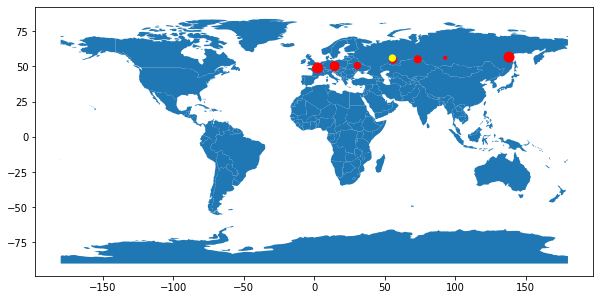

In [8]:
people = [i for i in list(cities['n_people'])]
m  = max(people)
coef = 100/m
people = [coef * i for i in people]

colors = ['red' for i in range(len(people))]
people.append(40)
colors.append('yellow')

cities = cities.iloc[: , :13]
final_location = final_location.iloc[: ,:13]

cities = cities.append(pd.Series(final_location.values.tolist()[0], index=cities.columns[:len(final_location.values.tolist()[0])]), ignore_index=True)
geometry = [Point(xy) for xy in zip(cities['lng'], cities['lat'])]
gdf      = GeoDataFrame(cities, geometry=geometry)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# gdf_final.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='green', markersize=20);
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color=colors, markersize=people);

In [9]:
print(f"The perfect location for a conference that minimizes jet lag is {final_location['city_ascii'].values[0]}, {final_location['admin_name'].values[0]}, {final_location['country'].values[0]}.")

The perfect location for a conference that minimizes jet lag is Burayevo, Bashkortostan, Russia.
